# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
    * [Background](#background)
    * [Problem Description](#problem)
    * [Interest / Target Audience](#interest)
    
* [Data Acquisition & Result](#data)
    * [Data Sources](#datasources)
        * [Borough Crime Data](#data1)
        * [Neighborhoods Data](#data2)
        * [Neighborhoods Population Data](#data3)
        * [Neighborhoods Venues Detail](#data4)
    * [Result Dataset](#result)

## Introduction: Business Problem<a name="introduction"></a>
Beside its multicultural, dynamic and attractive environment, crime rate in some boroughs of NY is also high compare to other boroughs. This project will help the stakeholder to find a comparatively safe and secure location for opening a new business of Grocery Store in New York.

First, we will choose the *__safest borough__* by analyzing crime data and then will short list neighborhoods in the safest boroughs having *__low competition but heavy population__*.

By making use of our data science tools and analyzing data, most promising neighborhoods in the safest borough will be presented to the stakeholder for their final selection process.

## Data: <a name="data"></a>
To satisfy our problem description, following are the factors which will influence stakeholder for final decision making.

* Finding the safest borough based on crime statistics:
* Gathering neighborhoods venues and population data within the safest borough:
* Choosing the most promising neighborhoods for final selection.

Following data sources will be needed to extract/generate the required information:

- **1. Borough Crime Data**<br><a name="data1"></a>
To find safest borough, real world data of NYPD complaint records will be collected from NYC Open Data source. This dataset includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD). The link to dataset which will be used is https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243.

- **2. Neighborhoods Data**<br><a name="data2"></a>
Neighborhoods in each borough will be collected from open data source dataset. Along with neighborhoods detail this dataset is also contain geolocation of each neighborhood. Out of this dataset, neighborhoods of safest borough will be selected for further analysis based on population and venues. The link to dataset which will be used is https://geo.nyu.edu/catalog/nyu_2451_34572

- **3. Neighborhoods Population Data**<br><a name="data3"></a>
To make grocery store business successful, population is one of the key features which should be taken into consideration for analysis. For our project, neighborhoods population data will be collected from NYC Open Data Source. This dataset contains 2010 census data at the Neighborhood Tabulation Area (NTA) level. We will use this data along with venues detail to compile our final neighborhoods selection. The link to dataset which will be used is https://data.cityofnewyork.us/City-Government/Census-Demographics-at-the-Neighborhood-Tabulation/rnsn-acs2

- **4. Neighborhoods Venues Detail**<br><a name="data4"></a>
Neighborhoods geolocation coordinates will be used in *__Foursquare API__* to explore and fetch the venues data.

### Importing all the necessary Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

mpl.style.use('ggplot') # optional: for ggplot-like style

%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

print('Libraries imported.')

Libraries imported.


### 1. Borough Crime Data<br>
**NYPD Complaint Records**<br>
Features of the Complaint Records

- CMPLNT_NUM - Complaint Number)<br>
- CMPLNT_FR_DT - (Data of Exact Crime Event)<br>
- RPT_DT - Crime Report Date<br>
- BORO_NM - Borough Name<br>
- KY_CD - Offense Key Code)<br>
- OFNS_DESC - Offense Description<br>
- LAW_CAT_CD - Level of Offense<br>
- LATITUDE - Latitude Coordinate<br>
- LONGITUDE - Longitude Coordinate<br>

Dataset Link: https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243.

### Reading from the Dataset
In order to save the amount of time and internet bandwidt, dataset has been downloaded and named as "NYPD_Complaint_Data.csv".

In [2]:
#Loading data from CSV file downloaded from above mentioned link.
crime_source = pd.read_csv('NYPD_Complaint_Data.csv')

#Selcting the required features from the source data.
columns = ['CMPLNT_NUM','CMPLNT_FR_DT','RPT_DT','BORO_NM','KY_CD','OFNS_DESC','LAW_CAT_CD','Latitude','Longitude']
crime_data = crime_source[columns]

Renaming the columns for better understanding of the data.

In [3]:
crime_data.columns = ['Number','Crime_Date','Report_Date','Borough','Ofns_Code','Ofns_Desc','Ofns_Category','Latitude','Longitude']
crime_data.head()

,Number,Crime_Date,Report_Date,Borough,Ofns_Code,Ofns_Desc,Ofns_Category,Latitude,Longitude
0,466502077,03/30/2020,03/31/2020,BROOKLYN,341,PETIT LARCENY,MISDEMEANOR,40.656991,-73.876574
1,303191835,03/28/2020,03/30/2020,BROOKLYN,104,RAPE,FELONY,40.674583,-73.930222
2,735488557,03/29/2020,03/29/2020,BRONX,341,PETIT LARCENY,MISDEMEANOR,40.830443,-73.871349
3,315962428,03/29/2020,03/29/2020,BRONX,341,PETIT LARCENY,MISDEMEANOR,40.817878,-73.916957
4,165437868,03/27/2020,03/27/2020,QUEENS,344,ASSAULT 3 & RELATED OFFENSES,MISDEMEANOR,40.752011,-73.935872


Check the shape of dataframe 

In [4]:
crime_data.shape

(108058, 9)

Cleaning the data by dropping rows with invalid data

In [5]:
crime_data.dropna(inplace=True)
crime_data.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Crimes in different boroughs

In [6]:
crime_data['Borough'].value_counts()

BROOKLYN         31028
MANHATTAN        26911
BRONX            23409
QUEENS           22097
STATEN ISLAND     4535
Name: Borough, dtype: int64

Crimes in different boroughs according to offense catgory.

In [7]:
crime_data.groupby(["Borough", "Ofns_Category"]).size()

Borough        Ofns_Category
BRONX          FELONY            6699
               MISDEMEANOR      12570
               VIOLATION         4140
BROOKLYN       FELONY           10339
               MISDEMEANOR      15691
               VIOLATION         4998
MANHATTAN      FELONY            8492
               MISDEMEANOR      14782
               VIOLATION         3637
QUEENS         FELONY            7242
               MISDEMEANOR      11170
               VIOLATION         3685
STATEN ISLAND  FELONY            1090
               MISDEMEANOR       2544
               VIOLATION          901
dtype: int64

Pivoting the table to better understand the data by ofense category per borough.

In [8]:
pd.pivot_table(crime_data,
   values=['Number'],
   index=['Borough'],
   columns=['Ofns_Category'],
   aggfunc=len, fill_value=0, margins=True)

Number                              
Ofns_Category FELONY MISDEMEANOR VIOLATION     All
Borough                                           
BRONX           6699       12570      4140   23409
BROOKLYN       10339       15691      4998   31028
MANHATTAN       8492       14782      3637   26911
QUEENS          7242       11170      3685   22097
STATEN ISLAND   1090        2544       901    4535
All            33862       56757     17361  107980

In [9]:
crime_data.describe()

,Number,Ofns_Code,Latitude,Longitude
count,1.079800e+05,107980.000000,107980.000000,107980.000000
mean,5.490200e+08,306.232089,40.736614,-73.924089
std,2.600246e+08,157.644106,0.082638,0.076551
min,1.000104e+08,102.000000,40.500216,-74.254743
25%,3.228685e+08,118.000000,40.675284,-73.971835
50%,5.487085e+08,341.000000,40.734025,-73.927136
75%,7.744989e+08,351.000000,40.811518,-73.881433
max,9.999971e+08,678.000000,40.912723,-73.700720


In [377]:
#df_crime_bor = crime_data.groupby(["Borough"]).count()
df_crime_bor = crime_data['Borough'].value_counts().to_frame().reset_index()
df_crime_bor.columns = ['Borough','Crime_Reported']

df_crime_bor_cat = ser = crime_data.groupby(["Borough", "Ofns_Category"]).Number.count().unstack()

Bulding graphs to better visualize the crime data

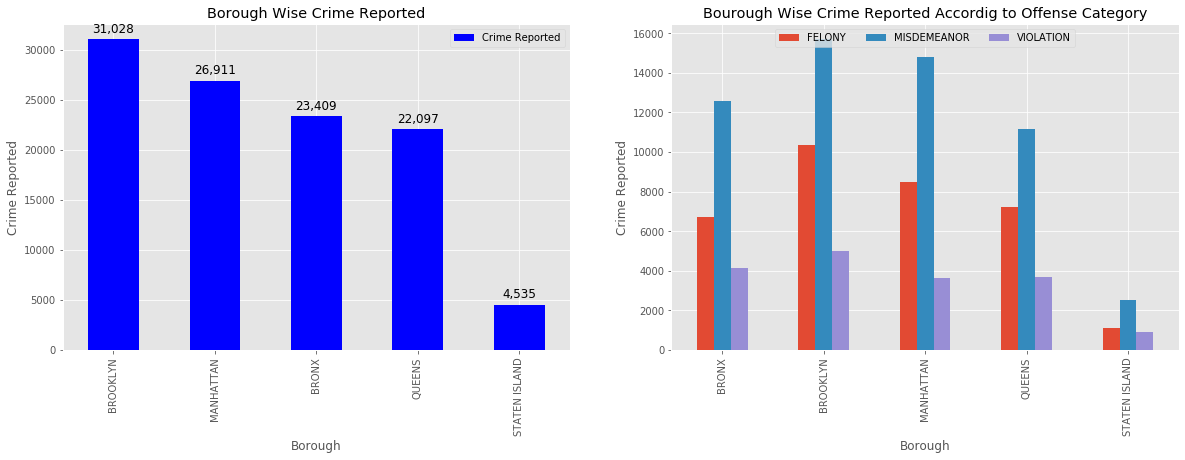

In [379]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)

# Subplot 1: Hist plot
df_crime_bor.plot(x='Borough', y='Crime_Reported', kind='bar', color='blue', figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Borough Wise Crime Reported')
ax0.set_xlabel('Borough')
ax0.set_ylabel('Crime Reported')
for p in ax0.patches:
    label = format(np.round(p.get_height(),decimals=0),",")
    ax0.annotate(label, 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 12
               )
    ax0.legend(['Crime Reported'])

# Subplot 2: Line plot
df_crime_bor_cat.plot(kind='bar', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Bourough Wise Crime Reported Accordig to Offense Category')
ax1.set_xlabel('Borough')
ax1.set_ylabel('Crime Reported')
ax1.legend(loc='upper center', ncol=3)

plt.show()

Sorting the data based on crimes reported to get the top two Boroughs

In [12]:
df_crime_bor.sort_values(by='Crime_Reported')

,Crime_Reported
STATEN ISLAND,4535
QUEENS,22097
BRONX,23409
MANHATTAN,26911
BROOKLYN,31028


#### Defining the function to get the coordinates of an address

In [18]:
def get_coordinates(address):
    try:
        geolocator = Nominatim(user_agent="NY_Explorer")
        location = geolocator.geocode(address)
        lat = location.latitude
        lon = location.longitude
        return [lat, lon]
    except:
        return [None, None]

Getting the geo location (Latitude & Longitude) for New York

In [21]:
address = 'New York, US'
latitude = get_coordinates(address)[0]
longitude = get_coordinates(address)[1]
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


Getting the locations of all borough to plot on the map

In [383]:
df_crime_bor['Latitude'] = df_crime_bor.apply(lambda row: get_coordinates(row['Borough']+", NY")[0], axis=1)
df_crime_bor['Longitude'] = df_crime_bor.apply(lambda row: get_coordinates(row['Borough']+", NY")[1], axis=1)
df_crime_bor.head()

,Borough,Crime_Reported,Latitude,Longitude
0,BROOKLYN,31028,40.650104,-73.949582
1,MANHATTAN,26911,40.789624,-73.959894
2,BRONX,23409,40.846651,-73.878594
3,QUEENS,22097,40.749824,-73.797634
4,STATEN ISLAND,4535,40.583456,-74.149605


#### Plotting a map based on this crime data using Folium

In [405]:
# Create a map object
ny_map = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# Instantiate a feature group in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the crimes data and add each to the incidents feature group
for lat, lng, label in zip(df_crime_bor['Latitude'], df_crime_bor['Longitude'],
                            df_crime_bor['Borough']+" [Total Crimes: "+df_crime_bor['Crime_Reported'].map(str)+"]"):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        ),
        folium.features.Marker([lat, lng], popup=label).add_to(ny_map)
    )

# Display the map
ny_map

### 2. Neighborhoods Data<br>
**NY Neighborhood Dataset**<br>
This dataset is in the form of JSON file out of which we will be working on following selected features only.

- ['properties']['borough'] - (Borough Name)<br>
- ['properties']['name'] - (Neighborhood Name)<br>
- ['geometry']['coordinates'][1] - (Latitude)<br>
- ['geometry']['coordinates'][0] - (Longitude)<br>

Dataset Link: https://geo.nyu.edu/catalog/nyu_2451_34572.

### Reading from the Dataset
In order to save the amount of time and internet bandwidt, data has been downloaded localy and named as "NY_Neighborhood_data.JSON".

#### Load and explore the data
Next, let's load the data.

In [13]:
with open('NY_Neighborhood_data.JSON') as json_data:
    newyork_data = json.load(json_data)
    
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods.

In [14]:
#Define a new variable that includes this data.
neighborhoods_data = newyork_data['features']

#Let's take a look at the first item in this list.
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe
Transforming data of nested dictionaries into a *pandas* dataframe.

In [15]:
#Creating an empty dataframe with columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [16]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
#Quickly examine the resulting dataframe.
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [17]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Getting the neighborhood data for selected tow low crime rate boroughs i.e. **Staten Island** and **Queens**

In [116]:
df_neighbors = neighborhoods[neighborhoods['Borough'].isin(['Staten Island','Queens'])].reset_index(drop=True)
df_neighbors.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


Exploring the borough wise neighborhood data size

In [117]:
df_neighbors['Borough'].value_counts()

Queens           81
Staten Island    63
Name: Borough, dtype: int64

### 3. Neighborhoods Population Data<br>
**NY Neighborhood Population Dataset**<br>
Required features of datset.

- geographic_area_borough - Borough Name<br>
- geographic_area_neighborhood_tabulation_area_nta_name - NTA Neighborhood Name<br>
- total_population_2010_number - Population<br>

Dataset Link: https://data.cityofnewyork.us/City-Government/Census-Demographics-at-the-Neighborhood-Tabulation/rnsn-acs2

### Reading From Population  Dataset
In order to save the amount of time and internet bandwidt, dataset has been downloaded and named as "NY_Neighborhood_Population_Data.csv".

In [148]:
#Loading data from CSV file downloaded from above mentioned link.
population_source = pd.read_csv('NY_Neighborhood_Population_Data.csv')

#Selcting the required features from the source data.
columns = ['geographic_area_borough','geographic_area_neighborhood_tabulation_area_nta_name','total_population_2010_number']
population_data = population_source[columns]

Renaming the columns heading for better understanding the data

In [149]:
population_data.columns = ['Borough','Neighborhood','Population']
population_data.head()

,Borough,Neighborhood,Population
0,Bronx,Claremont-Bathgate,31078.0
1,Bronx,Eastchester-Edenwald-Baychester,34517.0
2,Bronx,Bedford Park-Fordham North,54415.0
3,Bronx,Belmont,27378.0
4,Bronx,Bronxdale,35538.0


In [406]:
df_locations = pd.merge(df_neighbors, population_data, how='left', on=['Borough','Neighborhood'])
df_locations.head()

,Borough,Neighborhood,Latitude,Longitude,Population
0,Queens,Astoria,40.768509,-73.915654,78793.0
1,Queens,Woodside,40.746349,-73.901842,45099.0
2,Queens,Jackson Heights,40.751981,-73.882821,108152.0
3,Queens,Elmhurst,40.744049,-73.881656,88427.0
4,Queens,Howard Beach,40.654225,-73.838138,NaN


In [408]:
df_locations.shape

(144, 5)

#### Droping rows with "NaN" values because popluation data was not available in this particular dataset

In [409]:
df_locations.dropna(inplace=True)
df_locations.shape

(39, 5)

Plotting the population data on the map to have a better visualization

In [428]:
# Creating a map object
ny_map_population = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# Instantiate a feature group in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the population data and add each to the incidents feature group
for lat, lng, label in zip(df_locations['Latitude'], df_locations['Longitude'],
                            df_locations['Neighborhood']+" [Population: "+df_locations['Population'].astype(int).map(str)+"]"):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            popup=label,
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    ).add_to(ny_map_population)

# Display the map object
ny_map_population

### 4. Neighborhoods Venues Detail**<br>
***Eexploring and fetch the venues data using Foursquare API***

Define Foursquare Credentials and Version

In [429]:
client_id = 'RG313Y04XETBTVNVNBS45H5SOM2TFDZG04X5RY1LLAZJRMZ1' # your Foursquare ID
client_secret = 'YK4T3RV1PD4B0BSW10L0EZYU3YSTHPIMHCN3XON1NTWITYK1' # your Foursquare Secret
version = '20180605' # Foursquare API version
limit = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

Creating function to get nearby venues of selected neighborhoods

In [430]:
#Category IDs corresponding to Food & Drink Shop
#Taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

store_categories = ['4bf58dd8d48988d1f9941735','5370f356bcbc57f1066c94c2','4bf58dd8d48988d11d951735',
                    '4bf58dd8d48988d11e951735','5e18993feee47d000759b256','58daa1558bbb0b01f18ec1ca',
                    '4bf58dd8d48988d1fa941735','4bf58dd8d48988d10e951735','56aa371be4b08b9a8d573550',
                    '4bf58dd8d48988d1f5941735','4bf58dd8d48988d118951735','50aa9e744b90af0d42d5de0e',
                    '58daa1558bbb0b01f18ec1e8','4bf58dd8d48988d186941735','52f2ab2ebcbc57f1066b8b45',
                    '56aa371be4b08b9a8d573564','53e0feef498e5aac066fd8a9','52f2ab2ebcbc57f1066b8b46',
                    '58daa1558bbb0b01f18ec1e5','4bf58dd8d48988d119951735','52f2ab2ebcbc57f1066b8b1c']

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    print('Obtaining venues around selected locations:', end='')
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        for v in results:        
            # Checking the venue category from the categories list
            if v['venue']['categories'][0]['id'] in store_categories:
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name'])])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print(' done.')
    return(nearby_venues)

In [431]:
venues_data = getNearbyVenues(names=df_locations['Neighborhood'],
                              latitudes=df_locations['Latitude'],
                              longitudes=df_locations['Longitude']
                             )

Obtaining venues around selected locations: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


Checking the size of the resulting dataframe

In [432]:
print(venues_data.shape)
venues_data.head()

(74, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
1,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
2,Astoria,40.768509,-73.915654,United Brothers Fruit Markets,40.766178,-73.919932,Grocery Store
3,Astoria,40.768509,-73.915654,Mediterranean Foods,40.765579,-73.919123,Food & Drink Shop
4,Astoria,40.768509,-73.915654,Muho Liquors,40.765148,-73.913939,Liquor Store


In [439]:
df_venues = venues_data['Neighborhood'].value_counts().to_frame().reset_index()
df_venues.columns = ['Neighborhood','Venues']
df_venues.head()

,Neighborhood,Venues
0,Woodside,10
1,Astoria,8
2,Kew Gardens,4
3,Rego Park,4
4,Jackson Heights,4


In [440]:
locations_data = pd.merge(df_locations, df_venues, how='left', on=['Neighborhood'])

#Replace "NaN" values with 0 using Numpy
locations_data.replace(np.NaN,0,inplace=True)

#Make sure that dataframe has same number of rows as our originl locations detail before merging.
print("Size of final locations data is: ",locations_data.shape)
locations_data.head()

Size of final locations data is:  (39, 6)


,Borough,Neighborhood,Latitude,Longitude,Population,Venues
0,Queens,Astoria,40.768509,-73.915654,78793.0,8.0
1,Queens,Woodside,40.746349,-73.901842,45099.0,10.0
2,Queens,Jackson Heights,40.751981,-73.882821,108152.0,4.0
3,Queens,Elmhurst,40.744049,-73.881656,88427.0,0.0
4,Queens,Corona,40.742382,-73.856825,57658.0,2.0


#### Plotting a cluster map to show the neighborhood wise venues detail

In [443]:
# Creatig a map object
ny_map_venues = folium.Map(location = [latitude, longitude], zoom_start = 9.5)

# Instantiate a mark cluster object for the venues in the dataframe
incidents = plugins.MarkerCluster().add_to(ny_map_venues)

# Loop through the dataframe and add each data point to the mark cluster
for lat, lng, label in zip(locations_data['Latitude'], locations_data['Longitude'],
                locations_data['Borough']+", "+
                locations_data['Neighborhood']+" [Venues: "+locations_data['Venues'].astype(int).map(str)+"]"):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# Display map
ny_map_venues